In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
plt.rcParams['figure.figsize'] = (8, 5)
sns.set_style("whitegrid")
pd.options.display.max_rows=1000

In [2]:
df = pd.read_csv('/home/pybokeh/Downloads/portland-oregon-average-monthly-.csv', index_col=0)

### Get number of rows and columns: (rows, columns)

In [3]:
df.shape

(115, 1)

In [4]:
df

,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
Month,
1960-01,648
1960-02,646
1960-03,639
1960-04,654
1960-05,630
1960-06,622
1960-07,617
1960-08,613
1960-09,661


In [5]:
df.index[114]

'Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982'

Remove the last row or row containing index = 'Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982'

In [6]:
df.drop(df.index[114], inplace=True)

In [7]:
df.tail()

,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
Month,
1969-02,1425
1969-03,1419
1969-04,1432
1969-05,1394
1969-06,1327


Since we'll be using libraries that expect the index to consist of actual dates, convert the string representation of the dates into actual Python dates:

In [8]:
df.index = pd.to_datetime(df.index)

Rename columns:

In [9]:
df.columns = ['Riders']

Make the `Riders` column of type integer:

In [10]:
df['Riders'] = df['Riders'].astype(int)
df['Riders'] = df.Riders.apply(lambda x: x * 100)
df.index.name = None

In [11]:
df.head()

,Riders
1960-01-01,64800
1960-02-01,64600
1960-03-01,63900
1960-04-01,65400
1960-05-01,63000


In [12]:
df.tail()

,Riders
1969-02-01,142500
1969-03-01,141900
1969-04-01,143200
1969-05-01,139400
1969-06-01,132700


The web [site](https://datamarket.com/data/set/22w6/portland-oregon-average-monthly-bus-ridership-100-january-1973-through-june-1982-n114#!ds=22w6&display=line) that provided the data said the data is for 1973 thru 1982, but the actual data is from 1960 to 1969.  It is probably a mistake and so we will correct the data:

In [13]:
start = datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df.index = date_list

In [14]:
df.head()

,Riders
1973-01-01,64800
1973-02-01,64600
1973-03-01,63900
1973-04-01,65400
1973-05-01,63000


In [15]:
df.tail()

,Riders
1982-02-01,142500
1982-03-01,141900
1982-04-01,143200
1982-05-01,139400
1982-06-01,132700


So with our data finally corrected, we can plot the data:

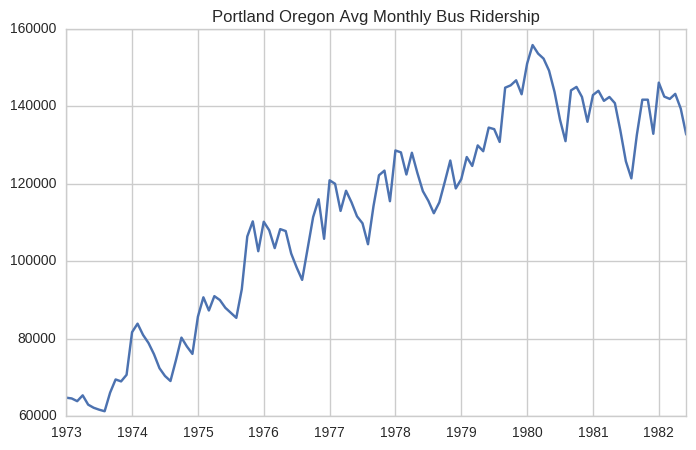

In [16]:
df.Riders.plot()
plt.title("Portland Oregon Avg Monthly Bus Ridership")
plt.show()

### Import necessary libraries for time series analysis

In [17]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### Decompose the time series data into its observed, trend, seasonal, and residual components

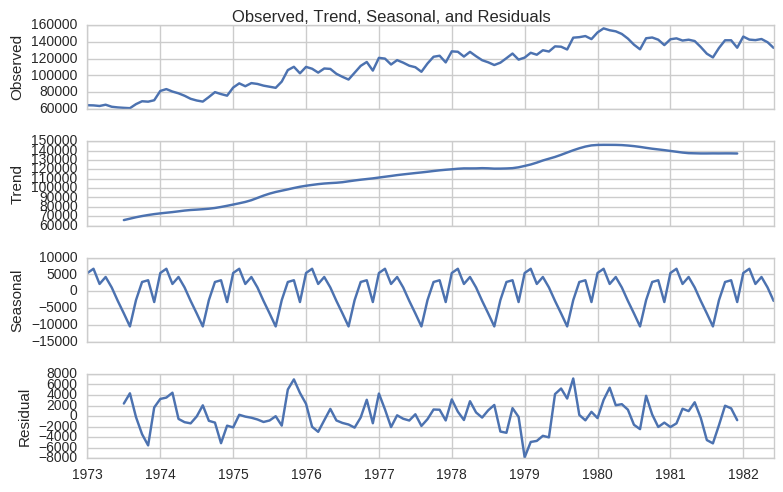

In [18]:
decomposition = seasonal_decompose(df.Riders, freq=12)
decomposition.plot()
plt.suptitle("Observed, Trend, Seasonal, and Residuals")
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

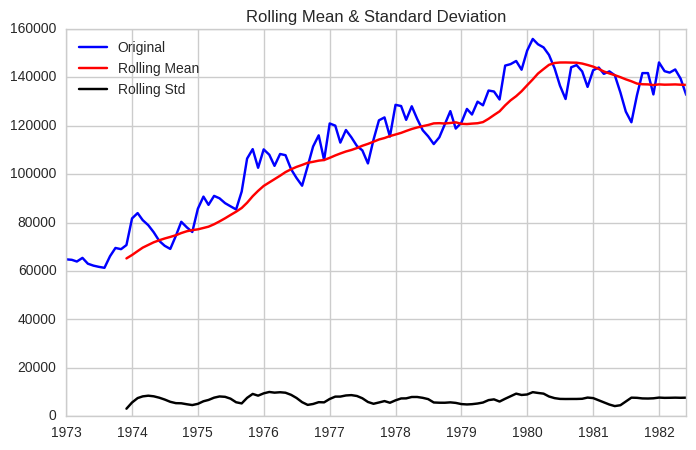

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (5%)             -2.890611
Critical Value (1%)             -3.496818
Critical Value (10%)            -2.582277
dtype: float64


In [20]:
test_stationarity(df.Riders)

Since the `Test Statistic` is not smaller than any of the critical values, the time series is non-stationary.

In [21]:
df['first_difference'] = df.Riders - df.Riders.shift(1)

In [22]:
df.head(10)

,Riders,first_difference
1973-01-01,64800,NaN
1973-02-01,64600,-200.0
1973-03-01,63900,-700.0
1973-04-01,65400,1500.0
1973-05-01,63000,-2400.0
1973-06-01,62200,-800.0
1973-07-01,61700,-500.0
1973-08-01,61300,-400.0
1973-09-01,66100,4800.0
1973-10-01,69500,3400.0


In [23]:
df.Riders.head()

1973-01-01    64800
1973-02-01    64600
1973-03-01    63900
1973-04-01    65400
1973-05-01    63000
Name: Riders, dtype: int64

In [24]:
df.Riders.shift(1).head(10)

1973-01-01        NaN
1973-02-01    64800.0
1973-03-01    64600.0
1973-04-01    63900.0
1973-05-01    65400.0
1973-06-01    63000.0
1973-07-01    62200.0
1973-08-01    61700.0
1973-09-01    61300.0
1973-10-01    66100.0
Name: Riders, dtype: float64

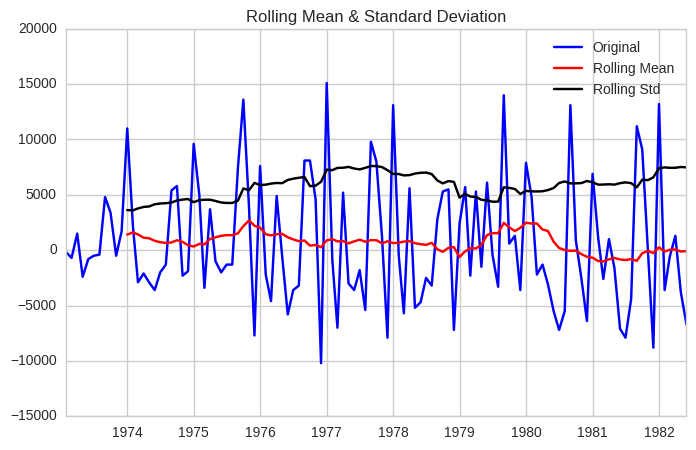

Results of Dickey-Fuller Test:
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (5%)             -2.890611
Critical Value (1%)             -3.496818
Critical Value (10%)            -2.582277
dtype: float64


In [25]:
test_stationarity(df.first_difference.dropna(inplace=False))

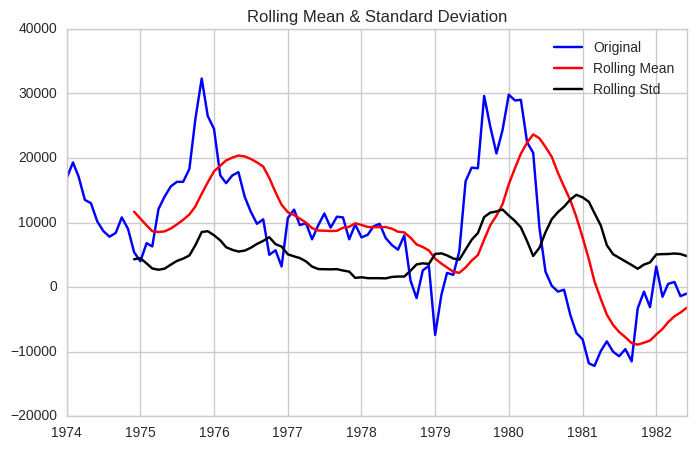

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (5%)            -2.891516
Critical Value (1%)            -3.498910
Critical Value (10%)           -2.582760
dtype: float64


In [26]:
df['seasonal_difference'] = df.Riders - df.Riders.shift(12)  
test_stationarity(df.seasonal_difference.dropna(inplace=False))

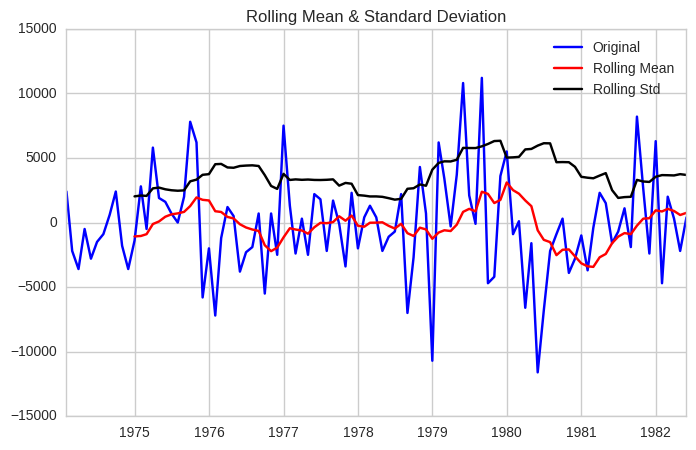

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (5%)           -2.890906e+00
Critical Value (1%)           -3.497501e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [27]:
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)  
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

Since our `Test Statistic` is less than the critical values, the time series is now stationary with a high degree of confidence.

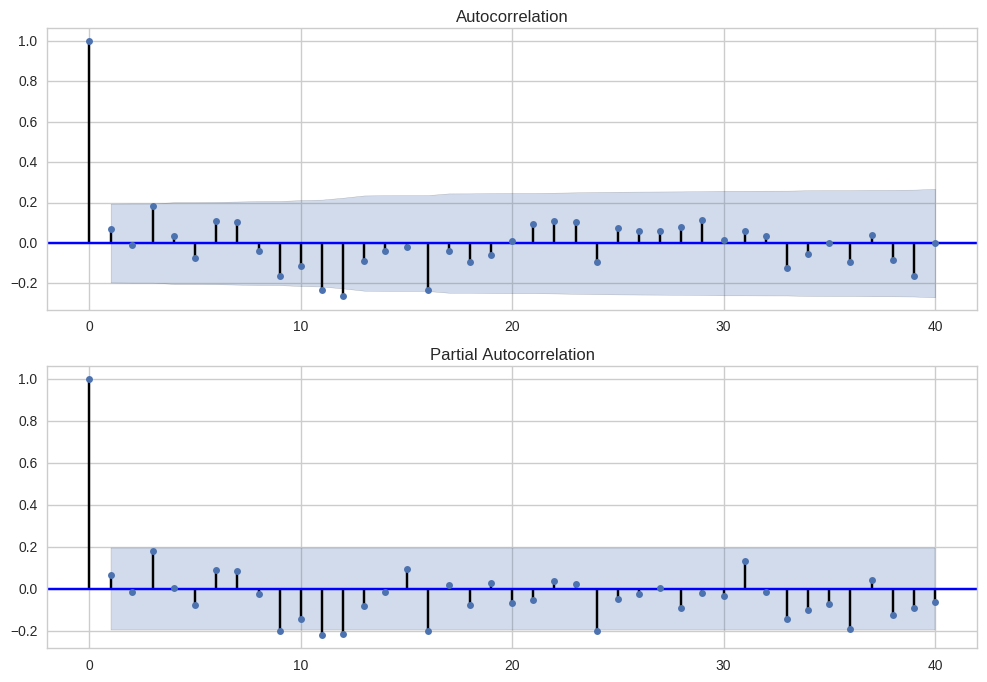

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [30]:
df.tail()

,Riders,first_difference,seasonal_difference,seasonal_first_difference
1982-02-01,142500,-3600.0,-1500.0,-4700.0
1982-03-01,141900,-600.0,500.0,2000.0
1982-04-01,143200,1300.0,800.0,300.0
1982-05-01,139400,-3800.0,-1400.0,-2200.0
1982-06-01,132700,-6700.0,-1000.0,400.0


In [31]:
%load_ext rpy2.ipython

In [32]:
df.reset_index(inplace=True)

In [33]:
df.rename(columns={'index':'Date'}, inplace=True)

In [34]:
df.tail()

,Date,Riders,first_difference,seasonal_difference,seasonal_first_difference
109,1982-02-01,142500,-3600.0,-1500.0,-4700.0
110,1982-03-01,141900,-600.0,500.0,2000.0
111,1982-04-01,143200,1300.0,800.0,300.0
112,1982-05-01,139400,-3800.0,-1400.0,-2200.0
113,1982-06-01,132700,-6700.0,-1000.0,400.0


In [35]:
%R -i df

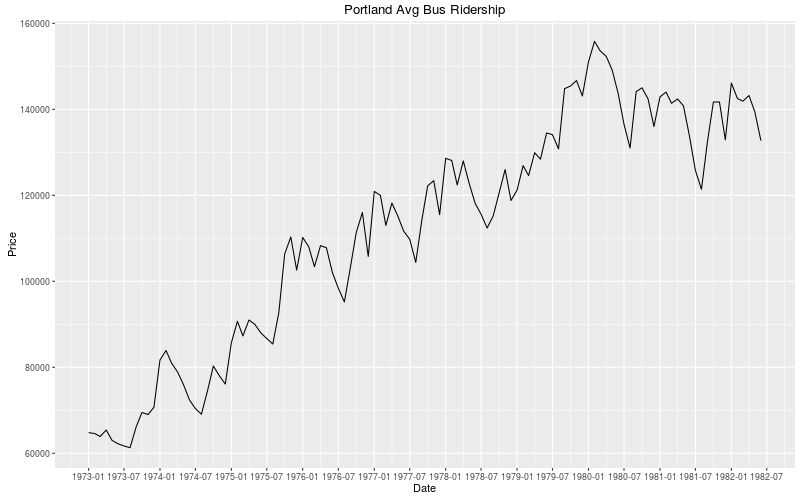

In [37]:
%%R -w 800 -h 500 -u px # Set size of chart.  Instead of px, you can also choose 'in', 'cm', or 'mm'
df = as.data.frame(df)  # ensure dataframe that was passed in from Python will be R's dataframe type
library(ggplot2)
library(scales)
p = ggplot(df, aes(df$Date, df$Riders))
p = p + 
    geom_line() +
    ggtitle("Portland Avg Bus Ridership") +
    scale_x_datetime(labels=date_format("%Y-%m"), breaks = date_breaks("6 months")) +
    xlab("Date") +
    ylab("Price")
print(p)

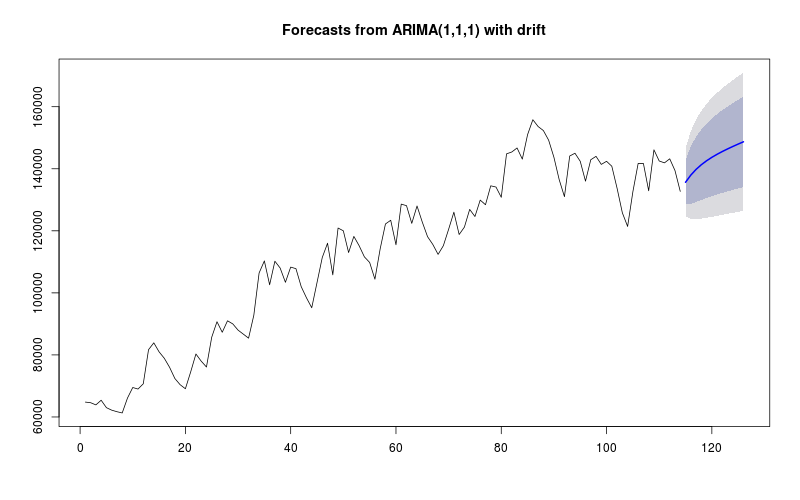

In [43]:
%%R -w 800 -h 500 -u px
df = as.data.frame(df)
library(forecast)
mymodel <- auto.arima(df$Riders)
f_aa <- forecast(mymodel, h=12)
plot(f_aa)

In [45]:
%%R -w 800 -h 500 -u px
df = as.data.frame(df)
library(forecast)
auto.arima(df$Riders, stepwise=FALSE, approximation=FALSE)

Series: df$Riders 
ARIMA(0,1,2) with drift         

Coefficients:
          ma1      ma2     drift
      -0.0853  -0.2756  644.2051
s.e.   0.0955   0.1058  332.7669

sigma^2 estimated as 30822939:  log likelihood=-1133.18
AIC=2274.36   AICc=2274.73   BIC=2285.27
